# Задание 3. Автоматическое обновление файла

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import requests
from urllib.parse import urlencode

In [32]:
def get_data(groups_link, groups_add_link, checks_link):

    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    
    groups_key = groups_link
    groups_url = base_url + urlencode(dict(public_key=groups_key))
    response_groups = requests.get(groups_url)
    download_groups = response_groups.json()['href']
    groups = pd.read_csv(download_groups, sep=';', header=0, names=['id', 'group'])

    groups_add_key = groups_add_link
    groups_add_url = base_url + urlencode(dict(public_key=groups_add_key))
    response_groups_add = requests.get(groups_add_url)
    download_groups_add = response_groups_add.json()['href']
    groups_add = pd.read_csv(download_groups_add, sep=',', header=0, names=['id', 'group'])

    checks_key = checks_link
    checks_url = base_url + urlencode(dict(public_key=checks_key))
    response_checks = requests.get(checks_url)
    download_checks = response_checks.json()['href']
    checks = pd.read_csv(download_checks, sep=';', header=0, names=['id', 'revenue'])

    return groups, groups_add, checks

In [33]:
groups, groups_add, checks = get_data('https://disk.yandex.ru/d/UhyYx41rTt3clQ', 
                                      'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ', 
                                      'https://disk.yandex.ru/d/pH1q-VqcxXjsVA')

In [34]:
def df_and_metrics(groups, groups_add, checks):

    # Объединяем таблицы в один DataFrame
    df_groups = pd.concat([groups, groups_add], ignore_index=True)
    df_groups = df_groups.merge(checks, how='left', on='id')
    df_groups['revenue'] = df_groups.revenue.fillna(0)
    df_groups['purchases'] = np.where(df_groups['revenue'] > 0, 1, 0)

        # Считаем основные метрики
        metrics = (df_groups.groupby('group', as_index=False)
                .agg({'id': 'count', 'revenue': 'sum', 'purchases': 'sum'})
                .rename(columns={'id': 'total_users', 'revenue': 'total_revenue'}))
        
        metrics['total_revenue'] = round(metrics.total_revenue, 2)
        metrics = metrics.assign(ARPU=round(metrics.total_revenue / metrics.total_users, 2), 
                                ARPPU=round(metrics.total_revenue / metrics.purchases, 2), 
                                CR=round(metrics.purchases / metrics.total_users * 100, 2))
        
        # Возвращаем объединенный DataFrame и таблицу с основными показателями
        return df_groups, metrics

IndentationError: unexpected indent (2125695574.py, line 10)

In [ ]:
df_groups, metrics = df_and_metrics(groups, groups_add, checks)

In [ ]:
metrics

,group,total_users,total_revenue,purchases,ARPU,ARPPU,CR
0,A,14693,92096.0,107,6.27,860.71,0.73
1,B,59883,481230.0,434,8.04,1108.82,0.72


In [ ]:
def visual_metrics(metrics):
    
    # Используем стиль и настройки для графиков
    plt.style.use('ggplot')
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))
    fig.suptitle('Основные метрики')

    # Визуализируем метрики
    sns.barplot(ax=ax[0], data=metrics, x='group', y='ARPU', hue='group', dodge=False)
    sns.barplot(ax=ax[1], data=metrics, x='group', y='ARPPU', hue='group', dodge=False)
    sns.barplot(ax=ax[2], data=metrics, x='group', y='CR', hue='group', dodge=False)

    # Устанавливаем заголовки для графиков
    ax[0].set_title('ARPU')
    ax[1].set_title('ARPPU')
    ax[2].set_title('CR')

    plt.tight_layout()  
    plt.show()

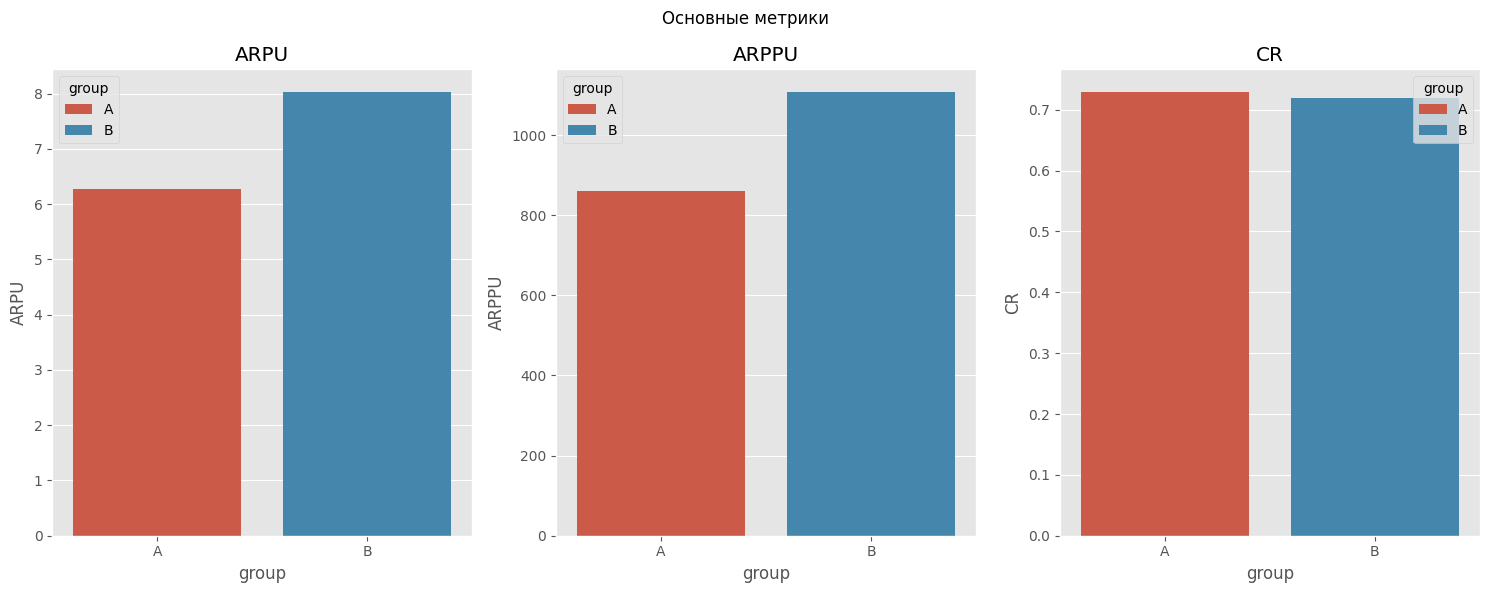

In [ ]:
visual_metrics(metrics)